# Overview

So you want to finetune an LLM for your company but you don't have the dataset?

No problem! You can use this simple approach to generate synthetic data and tons of examples that you can use to train your asssistant chatbot!

It is very straightforward:
- We call the LLM to generate a question, based on a text passage
- Then we call the LLM again to generate the answer, based on the generated question and the passage used to generate the question

There are many ways to create this question-answer style data, and I think this is the simplest one.

You could also instruct the LLM to generate the questions and the answers in the same call, using the same prompt and chain. But then you will have parsing challenges and you will need more engineering and code. It is known that LLM responses are very unpredictable, so I'm not a fan of the single call approach.

___

**Synthetic data:**

"Synthetic data creation" refers to the process of generating artificial data that mimics real-world data but isn't obtained from actual observations.

No Synthetic data generation is perfect and we should always have mechanisms and rules to filter out the question-answers pairs according to our use case and needs.

___

In this example I am using Mistral and [this dataset](https://www.kaggle.com/datasets/hinepo/harry-potter-books-in-pdf-1-7) to generate LLM finetuning data.

# Installs/Imports

In [1]:
%%time
from IPython.display import clear_output

! pip install -q -U transformers
! pip install -q -U accelerate
! pip install -q -U bitsandbytes

! pip install -qq -U langchain

clear_output()

CPU times: user 897 ms, sys: 199 ms, total: 1.1 s
Wall time: 1min 11s


In [2]:
%%time

import warnings
warnings.filterwarnings("ignore")
import gc
import time

import pandas as pd
import matplotlib.pyplot as plt

import torch

### transformers
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)

### quantization
import bitsandbytes as bnb

### langchain
from langchain.document_loaders import DirectoryLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate, LLMChain
from langchain.llms import HuggingFacePipeline
import langchain

clear_output()

CPU times: user 14.3 s, sys: 1.81 s, total: 16.1 s
Wall time: 23.5 s


In [3]:
print('torch version: ', torch.__version__)
print(f'transformers version: {transformers.__version__}')
print(f'bnb version: {bnb.__version__}')
print(f'langchain version: {langchain.__version__}')

torch version:  2.1.2
transformers version: 4.38.2
bnb version: 0.42.0
langchain version: 0.1.10


# CFG

- `MAX_CHUNKS`: Maximum number of chunks to generate synthetic data from
- `MIN_CHUNK_SIZE`: Minimum chunk length to use to generate Q/A pairs

In [4]:
class CFG:
    ### debug
    DEBUG = True
    MAX_CHUNKS = 50 if DEBUG else 1_000_000
    
    ### synthetic data settings
    MIN_CHUNK_SIZE = 1_000
    PAGES_TO_SKIP = 20
    
    ### split
    CHUNK_SIZE = 3000
    OVERLAP = 500      
    
    ### model
    MODEL_ID = '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1'
#     MODEL_ID = '/kaggle/input/mixtral/pytorch/8x7b-v0.1-hf/1'  
    
    ### paths
    PDF_FOLDER = '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/'
    OUTPUT_FOLDER = './'

# Document Loader

In [5]:
%%time

loader = DirectoryLoader(
    CFG.PDF_FOLDER,
#     glob = "./*.pdf", # all books
    glob = "./*Book 5*.pdf", # only 1 book
    loader_cls = PyPDFLoader,
    show_progress = True,
    use_multithreading = True
)

documents = loader.load()

print(f'We have {len(documents)} pages in total\n')

100%|██████████| 1/1 [00:16<00:00, 16.18s/it]

We have 891 pages in total

CPU times: user 16 s, sys: 90.9 ms, total: 16.1 s
Wall time: 16.2 s


# Text Splitter

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.CHUNK_SIZE,
    chunk_overlap = CFG.OVERLAP
)

texts = text_splitter.split_documents(documents)

print(f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 881 chunks from 891 pages


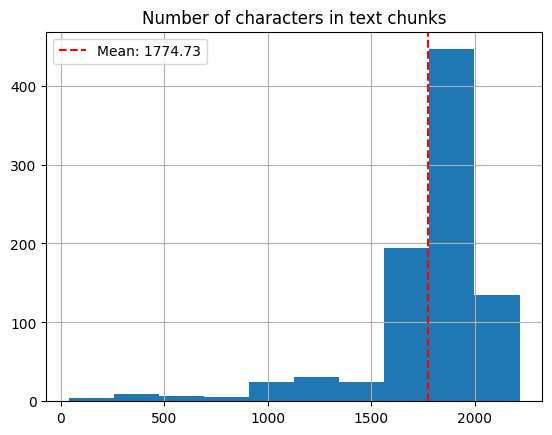

In [7]:
chunk_lengths = [len(chunk.page_content) for chunk in texts]

len_df = pd.DataFrame({'chunk': range(len(texts)), 'N_characters': chunk_lengths})

mean_len = len_df['N_characters'].mean()

len_df['N_characters'].hist()
plt.axvline(x=mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.2f}')
plt.title('Number of characters in text chunks')
plt.legend();

# Model

In [8]:
%%time

### quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = torch.float16,
    bnb_4bit_use_double_quant = True,
    llm_int8_enable_fp32_cpu_offload = True,
)

### model
model = AutoModelForCausalLM.from_pretrained(
    CFG.MODEL_ID,
    quantization_config = bnb_config,
    device_map = "auto",
    trust_remote_code = True,
#     attn_implementation = 'flash_attention_2',
)

### tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    CFG.MODEL_ID,
    trust_remote_code = True
)
tokenizer.pad_token = tokenizer.eos_token

### pipeline
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    eos_token_id = tokenizer.eos_token_id,
    do_sample = True,
    max_new_tokens = 512, 
    temperature = 0.8,
    top_p = 0.90,
)

### langchain pipeline
llm = HuggingFacePipeline(pipeline = pipe)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 20 s, sys: 15.3 s, total: 35.2 s
Wall time: 1min 31s


In [9]:
gc.collect()

51

# Question Chain

- Basic prompt. Can definitely be improved with prompt engineering!

In [10]:
prompt_to_generate_question = """
You are a helpful assistant that creates a question based on the passage you are given.

Read the passages below and create one question based on the most relevant information on the passage.

The question must be in the same language as the passage you are given.

Use only the following passage to create the question:

{passage}

Question:
"""


QUESTION_PROMPT = PromptTemplate(
#     template = prompt_to_generate_question,
    template = '[INST]' + prompt_to_generate_question + '[/INST]',
    input_variables = ["passage"]
)

question_chain = LLMChain(prompt=QUESTION_PROMPT, llm=llm)

# Answer Chain

- Basic prompt. Can definitely be improved with prompt engineering!

In [11]:
prompt_to_generate_answer = """
You are a helpful assistant that answers a given question based on a given passage.

The answer must be in the same language as the passage you are given.

Question: {question}

Use only the following passage to answer the question:

{passage}

Answer:
"""


ANSWER_PROMPT = PromptTemplate(
#     template = prompt_to_generate_answer,
    template = '[INST]' + prompt_to_generate_answer + '[/INST]',
    input_variables = ["question", "passage"]
)

answer_chain = LLMChain(prompt=ANSWER_PROMPT, llm=llm)

# Inference

- Synthetic data creation

In [12]:
df = pd.DataFrame(columns=['Question', 'Answer', 'Book', 'Page', 'Seconds'])

for doc_number, doc in enumerate(texts):
    
    start_time = time.time()
    
    doc_text = doc.page_content
    book = doc.metadata['source'].split('/')[-1]
    page = doc.metadata['page']
    
    if len(doc_text) >= CFG.MIN_CHUNK_SIZE and page >= CFG.PAGES_TO_SKIP:
        
        ### generate question
        generated_question = question_chain.invoke(
            {
                "passage": doc_text
            }
        )
        
        ### generate answer
        generated_answer = answer_chain.invoke(
            {
                "question": generated_question,
                "passage": doc_text
            }
        )
        
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 2)
        
        ### store in df
        new_data_point = {
            'Question': generated_question['text'],
            'Answer': generated_answer['text'],
            'Book': book,
            'Page': page,
            'Seconds': elapsed_time
        }
    
        df = pd.concat([df, pd.DataFrame([new_data_point])], ignore_index=True)
        
        if doc_number >= CFG.MAX_CHUNKS:
            break
    
### persist synthetic data
df.to_csv(f'{CFG.OUTPUT_FOLDER}synth_raw.csv', index=False)

clear_output()

In [13]:
### total time
print(f"Seconds taken to generate Q/A pairs: {round( sum(df['Seconds']), 2 )}")
print(f"\nMinutes taken to generate Q/A pairs: {round( sum(df['Seconds'])/60, 2 )}")

Seconds taken to generate Q/A pairs: 301.38

Minutes taken to generate Q/A pairs: 5.02


In [14]:
### average time
print(f"Average time (s) taken to generate Q/A pairs: {round( sum(df['Seconds'])/len(df), 2 )}")
print(f"\nAverage time (min) taken to generate Q/A pairs: {round( sum(df['Seconds'])/(60*len(df)), 2 )}")

Average time (s) taken to generate Q/A pairs: 8.15

Average time (min) taken to generate Q/A pairs: 0.14


# Filter Synthetic Dataset

- A bit of cleaning

In [15]:
df

,Question,Answer,Book,Page,Seconds
0,What happened to Harry in the passage and wha...,"In the passage, Harry is struggling with his ...",Harry Potter - Book 5 - The Order of the Phoen...,20,10.83
1,What is Harry doing under the Dursleys' window?,Harry is listening to the news under the Durs...,Harry Potter - Book 5 - The Order of the Phoen...,21,3.87
2,What is Harry feeling in the passage?,Harry is feeling hopeless and frustrated in t...,Harry Potter - Book 5 - The Order of the Phoen...,22,11.30
3,What is the main reason why Harry doesn't car...,The main reason why Harry doesn't care about ...,Harry Potter - Book 5 - The Order of the Phoen...,23,19.97
4,How does Harry feel about being stuck in Priv...,Harry feels frustrated and angry at being stu...,Harry Potter - Book 5 - The Order of the Phoen...,24,5.32
5,Who is Dudley Dursley accompanied by as he re...,Dudley Dursley is accompanied by his faithful...,Harry Potter - Book 5 - The Order of the Phoen...,25,7.89
6,What was Dudley's new talent that he discover...,"Based on the passage provided, Dudley's new t...",Harry Potter - Book 5 - The Order of the Phoen...,26,8.82
7,What is Harry's opinion of Dudley and his gan...,Harry's opinion of Dudley and his gang in the...,Harry Potter - Book 5 - The Order of the Phoen...,27,13.24
8,What is the nickname that Harry has for his c...,Harry has a nickname for his cousin Dudley ca...,Harry Potter - Book 5 - The Order of the Phoen...,28,4.44
9,What is Dudley's reaction to Harry's use of h...,"In the given passage, Dudley's reaction to Ha...",Harry Potter - Book 5 - The Order of the Phoen...,29,7.62


In [16]:
print(f'Raw synthetic dataset: {df.shape}')

### drop rows where 'passage' is mentioned
df = df[~df['Question'].str.contains('passage')].reset_index(drop=True)
df = df[~df['Answer'].str.contains('passage')].reset_index(drop=True)

print(f'No reference to "passage": {df.shape}')

### drop rows where the column Question is equal to the column Answer
df = df[df['Question'] != df['Answer']]

def replace_matching_substring(row):
    question = row['Question']
    answer = row['Answer']
    if question in answer:
        return answer.replace(question, '')
    else:
        return answer

df['Answer'] = df.apply(replace_matching_substring, axis=1)

### remove rows where 'Question' or 'Answer' is empty
df = df.dropna(subset=['Question', 'Answer'])

print(f'No parroting: {df.shape}')

### persist synthetic data
df.to_csv(f'{CFG.OUTPUT_FOLDER}synth_filtered.csv', index=False)

df

Raw synthetic dataset: (37, 5)
No reference to "passage": (26, 5)
No parroting: (26, 5)


,Question,Answer,Book,Page,Seconds
0,What is Harry doing under the Dursleys' window?,Harry is listening to the news under the Durs...,Harry Potter - Book 5 - The Order of the Phoen...,21,3.87
1,What is the main reason why Harry doesn't car...,The main reason why Harry doesn't care about ...,Harry Potter - Book 5 - The Order of the Phoen...,23,19.97
2,How does Harry feel about being stuck in Priv...,Harry feels frustrated and angry at being stu...,Harry Potter - Book 5 - The Order of the Phoen...,24,5.32
3,Who is Dudley Dursley accompanied by as he re...,Dudley Dursley is accompanied by his faithful...,Harry Potter - Book 5 - The Order of the Phoen...,25,7.89
4,What is the nickname that Harry has for his c...,Harry has a nickname for his cousin Dudley ca...,Harry Potter - Book 5 - The Order of the Phoen...,28,4.44
5,What is in the alleyway apart from Harry and ...,There is something in the alleyway apart from...,Harry Potter - Book 5 - The Order of the Phoen...,31,4.07
6,What happens to Harry when he tries to use th...,"When Harry tries to use the ""Expecto Patronum...",Harry Potter - Book 5 - The Order of the Phoen...,33,14.53
7,What is Mrs. Figg's occupation?,There is no question provided for me to answe...,Harry Potter - Book 5 - The Order of the Phoen...,35,3.74
8,What happened to Dudley and how did Harry hel...,"Dudley was unable to move on his own, so Harr...",Harry Potter - Book 5 - The Order of the Phoen...,36,5.29
9,What is the name of the character that materi...,The character that materializes in front of M...,Harry Potter - Book 5 - The Order of the Phoen...,37,6.12


# Check Dataset

In [17]:
RED = '\033[91m'
BLUE = '\033[94m'
ORANGE = '\033[93m'
RESET = '\033[0m' # Reset color to default

for row in range(len(df)):
    print(f'{RED}\nSource: {df.Book[row]} - Page: {df.Page[row]}{RESET}')
    print(f'{BLUE}\n{df.Question[row]}{RESET}')
    print(f'{ORANGE}\n{df.Answer[row]}\n{RESET}')
    print('*'*80)
    
    if row >= 10:
        break


Source: Harry Potter - Book 5 - The Order of the Phoenix.pdf - Page: 21

 What is Harry doing under the Dursleys' window?

 Harry is listening to the news under the Dursleys' window.

********************************************************************************

Source: Harry Potter - Book 5 - The Order of the Phoenix.pdf - Page: 23

 What is the main reason why Harry doesn't care about the headlines of the Daily Prophet and how did he react to the news about Voldemort's return?

 The main reason why Harry doesn't care about the headlines of the Daily Prophet is that he is only interested in news related to Voldemort's return. He no longer finds any other news important and throws the paper away. When Harry was lucky, there would also be owls carrying letters from his best friends, Ron and Hermione, but he had already given up on them bringing him any news. Harry is angry at Ron and Hermione because they are having fun at the Burrow while he is stuck in Privet Drive. He had thrown 

# Conclusions

In this example, basically I generated two columns (Question and Answer), so the result is meant to be used as a **Instruction Finetuning** dataset.

If you want to generate data for **Preference Finetuning**, you will need to create three columns: Question, Chosen Answer and Rejected Answer. Usually people do that by using two models (like GPT-4 and Llama-2-chat for example), and just assuming that GPT-4 answers are always better. This is not a true assumption but it works well enough and helps automating the data generation pipeline with no need for a human in the loop.

**<font color='orange'>If you liked it, don't forget to show your support with your upvote!</font>**

In case you are interested in LLM, check out my other notebooks related to this topic:

- [RAG](https://www.kaggle.com/code/hinepo/q-a-chatbot-with-llms-harry-potter)
- [Instruction Finetuning](https://www.kaggle.com/code/hinepo/llm-instruction-finetuning-wandb)
- [Preference Finetuning](https://www.kaggle.com/code/hinepo/llm-alignment-preference-finetuning)
- [Safeguards](https://www.kaggle.com/code/hinepo/llm-safeguards-and-guardrails)